In [1]:
import torch
import torch.nn as nn

from torchvision import datasets, transforms
import torch.optim as optim

import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

from tqdm.auto import tqdm

C:\Users\bielp\PycharmProjects\ia_2024\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Xarxes convolucionals

L'objectiu d'avui és la creació d'una xarxa convolucional que obtengui **com a mínim igual resultat que la xarxa completament connectada implementada la setmana anterior però amb menys paràmetres**. Per poder realitzar comparacions directes emprarem el mateix conjunt de dades.

Com objectius secundaris tenim:

1. Aprenentatge de noves estratègies per evitar `overfitting`.
2. Visualització dels resultats dels filtres convolucionals.

Primer de tot, com sempre, les dades:

In [2]:
DOWNLOAD = True
BATCH_SIZE = 64
EPOCHS = 5

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),  # mitjana, desviació típica
])

train = datasets.MNIST("../data", train=True, download=DOWNLOAD, transform=transform)
test = datasets.MNIST("../data", train=False, download=DOWNLOAD, transform=transform)

train_loader = torch.utils.data.DataLoader(train, BATCH_SIZE)
test_loader = torch.utils.data.DataLoader(test, BATCH_SIZE)

In [3]:
img, target = next(iter(train_loader))
print(img.shape)

torch.Size([64, 1, 28, 28])


## Definició de la xarxa

En primer lloc, reutilitzarem la xarxa (MLP) que varem dissenyar la sessió anterior:

In [4]:
model_mlp = nn.Sequential(
            torch.nn.Linear(784, 10),
            nn.ReLU(),
            torch.nn.Linear(10, 10),
            torch.nn.Dropout(0.2),
            nn.ReLU(),
            torch.nn.Linear(10, 1)
        )


En segon lloc, definirem la nostra primera xarxa convolucional:

1. Definir la primera xarxa convolucional. A continuació teniu una llista de les capes que podeu emprar:

- `Conv2d`: Capa convolucional en 2 dimensions ([enllaç](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html)). Com a paràmetres principals trobarem: ([visualització](https://github.com/vdumoulin/conv_arithmetic/blob/master/README.md))

  - in_channels: canals d'entrada.
  - out_channels : canals de sortida.
  - kernel_size: mida del filtre.
  - stride: desplaçament del filtre. Típicament pren per valor 1.
  - padding: ampliació de la imatge per evitar pèrdua de dimensionalitat.

- `MaxPool2d`: Capa de max pooling ([enllaç](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html#torch.nn.MaxPool2d)). Aquesta capa no té paràmetres entrenables. Però en té d'altres:

  - kernel_size: Mida del filtre del qual es seleccionarà el màxim.
  - stride: desplaçament del filtre.

- `Dropout`: Dropout és un mètode de regularització (evitar `overfitting`) que aproxima l'entrenament d'un gran nombre de xarxes neuronals amb diferents arquitectures en paral·lel. Durant l'entrenament, una part de les sortides de la capa s'ignoren aleatòriament o s'abandonen. Això té l'efecte de fer que la capa sembli i es tracti com una capa amb un nombre diferent de nodes i connectivitat a la capa anterior. En efecte, cada actualització d'una capa durant l'entrenament es realitza amb una vista diferent de la capa configurada. Hem d'especificar quines capes tenen `dropout` de manera individual. Té un únic paràmetre amb valor per defecte $p=0.5$ Els valors típics d'aquest paràmetre varien entre $0.5$ i $0.8$.

- `Linear`

- `ReLU`


In [18]:
model_cnn = nn.Sequential(
    torch.nn.Conv2d(in_channels= 1, out_channels= 16, kernel_size= 3, stride= 1, padding= 0),
    torch.nn.MaxPool2d(kernel_size=(2,2)), # 26 x 26 -> 13 x 13
    torch.nn.ReLU(),
    #TODO: COMPLETAR

    torch.nn.Flatten(),
    torch.nn.Linear(16 * 13 * 13, 128),
    torch.nn.ReLU(),
    torch.nn.Linear(128, 10),
    )

## Entrenament MLP

Aquesta part, per sort, no varia de la setmana anterior:




In [6]:
loss_fn = torch.nn.BCEWithLogitsLoss()    
learning_rate =  1e-3 # Hiperparàmetre
optimizer = optim.Adam(model_mlp.parameters(), lr=learning_rate)

In [7]:
running_loss = []
running_acc = []

running_test_loss = []
running_test_acc = []

for t in tqdm(range(EPOCHS), desc="Èpoques"):
    batch_loss = 0
    batch_acc = 0
    
    # Iteram els batches.
    for i_batch, (x, y) in tqdm(enumerate(train_loader), desc=f"Batches (Època {t + 1})"): 
        model_mlp.train() # Posam el model a mode entranament.
        
        x = x.reshape(x.shape[0], -1) # Aplanam la imatge.
        
        optimizer.zero_grad()

        # 1. PREDICCIÓ
        y_pred = model_mlp(x)

        # 2. CÀLCUL DE LA PÈRDUA
        # Computa la pèrdua: l'error de predicció vs el valor correcte
        # Es guarda la pèrdua en un array per futures visualitzacions

        y_binary = (y == 5)
        y_binary = y_binary.double()
        y_binary = y_binary.reshape(-1, 1)

        loss = loss_fn(y_pred, y_binary)

        #3. GRADIENT
        model_mlp.zero_grad()
        loss.backward()

        # Actualitza els pesos utilitzant l'algorisme d'actualització
        #4. OPTIMITZACIÓ
        with torch.no_grad():
            optimizer.step()
    
        # 5. AVALUAM EL MODEL
        model_mlp.eval() # Mode avaluació de la xarxa
        
        y_pred = model_mlp(x)
        y_pred_binary = (y_pred > 0.5).double()

        batch_loss += (loss_fn(y_pred, y_binary).detach())
        batch_acc += accuracy_score(y_pred_binary.detach(), y_binary.detach())

    running_loss.append(batch_loss / (i_batch + 1))
    running_acc.append(batch_acc / (i_batch + 1))

    batch_test_loss = 0
    batch_test_acc = 0
    
    for i_batch, (x, y) in enumerate(test_loader): 
        x = x.reshape(x.shape[0], -1) # Aplanam la imatge.
        
        y_binary = (y == 5)
        y_binary = y_binary.double()
        y_binary = y_binary.reshape(-1, 1)

        y_pred = model_mlp(x)
        y_pred_binary = (y_pred > 0.5).double()

        batch_test_loss += (loss_fn(y_pred, y_binary).detach())
        acc = accuracy_score(y_pred_binary.detach(), y_binary.detach())
        batch_test_acc += acc
        

    running_test_loss.append(batch_test_loss / (i_batch + 1))
    running_test_acc.append(batch_test_acc / (i_batch + 1))

Èpoques:   0%|          | 0/5 [00:00<?, ?it/s]
Batches (Època 1): 0it [00:00, ?it/s]
Batches (Època 1): 2it [00:00, 16.55it/s]
Batches (Època 1): 6it [00:00, 26.66it/s]
Batches (Època 1): 9it [00:00, 23.31it/s]
Batches (Època 1): 12it [00:00, 22.00it/s]
Batches (Època 1): 15it [00:00, 23.06it/s]
Batches (Època 1): 18it [00:00, 25.01it/s]
Batches (Època 1): 21it [00:00, 26.06it/s]
Batches (Època 1): 24it [00:00, 26.83it/s]
Batches (Època 1): 28it [00:01, 29.18it/s]
Batches (Època 1): 31it [00:01, 28.63it/s]
Batches (Època 1): 34it [00:01, 28.18it/s]
Batches (Època 1): 38it [00:01, 29.39it/s]
Batches (Època 1): 42it [00:01, 30.93it/s]
Batches (Època 1): 46it [00:01, 29.88it/s]
Batches (Època 1): 50it [00:01, 30.67it/s]
Batches (Època 1): 54it [00:01, 31.37it/s]
Batches (Època 1): 58it [00:02, 29.78it/s]
Batches (Època 1): 62it [00:02, 30.14it/s]
Batches (Època 1): 66it [00:02, 30.64it/s]
Batches (Època 1): 70it [00:02, 29.84it/s]
Batches (Època 1): 73it [00:02, 28.81it/s]
Batches (Època 

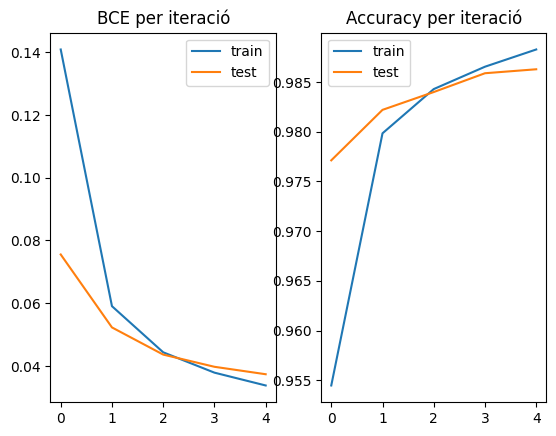

In [8]:
plt.subplot(1,2,1)
plt.title("BCE per iteració")
plt.plot(running_loss, label="train")
plt.plot(running_test_loss, label="test")
plt.legend()

plt.subplot(1,2,2)
plt.title("Accuracy per iteració")
plt.plot(running_acc, label="train")
plt.plot(running_test_acc, label="test")
plt.legend()
plt.show()

In [9]:
print(f"Accuracy de la darrera iteració {running_test_acc[-1]} amb test")

Accuracy de la darrera iteració 0.986265923566879 amb test





### Nombre de paràmetres entrenables d'una xarxa

**Feina a fer:**
1. Mostrar el nombre de paràmetres de la xarxa: 
```
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
```

In [11]:
#TODO

pytorch_total_params = sum(p.numel() for p in model_cnn.parameters() if p.requires_grad)
print(f"Nombre total de paràmetres entrenables: {pytorch_total_params}")

Nombre total de paràmetres entrenables: 347690


## Entrenament CNN

Ara repetirem el mateix que abans, adaptant el codi a la nova arquitectura:

In [21]:
loss_fn = torch.nn.CrossEntropyLoss()
learning_rate = 1e-3  # Hiperparàmetre
optimizer = optim.Adam(model_cnn.parameters(), lr=learning_rate)

running_loss = []
running_acc = []

running_test_loss = []
running_test_acc_cnn = []

#TODO: COPIAR I ADAPTAR

for t in tqdm(range(EPOCHS), desc="Èpoques"):
    batch_loss = 0
    batch_acc = 0
    
    # Entrenament
    for i_batch, (x, y) in tqdm(enumerate(train_loader), desc=f"Batches (Època {t + 1})", leave=False):
        model_cnn.train()  # mode entrenament
        
        optimizer.zero_grad()

        # 1️⃣ PREDICCIÓ
        y_pred = model_cnn(x)  # NO aplanam

        # 2️⃣ ETIQUETA binària (1 si és el dígit 5)
        # y_binary = (y == 5).double().reshape(-1, 1)
        
        # 3️⃣ CÀLCUL DE LA PÈRDUA
        loss = loss_fn(y_pred, y)

        # 4️⃣ BACKPROP + OPTIMITZACIÓ
        loss.backward()
        optimizer.step()
    
        # 5️⃣ AVALUACIÓ DEL BATCH
        model_cnn.eval()  # mode avaluació (per seguretat)
        with torch.no_grad():
            y_pred_eval = model_cnn(x)
            y_pred_class = torch.argmax(y_pred_eval, dim=1)
        
        batch_loss += loss_fn(y_pred_eval, y).detach()
        batch_acc += accuracy_score(y_pred_class.cpu(), y.cpu())

    running_loss.append(batch_loss / (i_batch + 1))
    running_acc.append(batch_acc / (i_batch + 1))

    # 🔍 VALIDACIÓ / TEST
    batch_test_loss = 0
    batch_test_acc = 0
    
    model_cnn.eval()
    with torch.no_grad():
        for i_batch, (x, y) in enumerate(test_loader): 
            y_pred = model_cnn(x)
            y_pred_class = torch.argmax(y_pred, dim=1)

            batch_test_loss += loss_fn(y_pred, y).detach()
            acc = accuracy_score(y_pred_class.cpu(), y.cpu())
            batch_test_acc += acc
        
    running_test_loss.append(batch_test_loss / (i_batch + 1))
    running_test_acc_cnn.append(batch_test_acc / (i_batch + 1))

Èpoques:   0%|          | 0/5 [00:00<?, ?it/s]
Batches (Època 1): 0it [00:00, ?it/s]
Batches (Època 1): 2it [00:00, 14.33it/s]
Batches (Època 1): 4it [00:00, 15.09it/s]
Batches (Època 1): 7it [00:00, 18.20it/s]
Batches (Època 1): 10it [00:00, 20.75it/s]
Batches (Època 1): 13it [00:00, 22.52it/s]
Batches (Època 1): 16it [00:00, 21.87it/s]
Batches (Època 1): 19it [00:00, 22.07it/s]
Batches (Època 1): 22it [00:01, 22.16it/s]
Batches (Època 1): 25it [00:01, 23.42it/s]
Batches (Època 1): 28it [00:01, 22.66it/s]
Batches (Època 1): 31it [00:01, 22.53it/s]
Batches (Època 1): 34it [00:01, 22.61it/s]
Batches (Època 1): 37it [00:01, 23.68it/s]
Batches (Època 1): 40it [00:01, 23.55it/s]
Batches (Època 1): 43it [00:01, 23.44it/s]
Batches (Època 1): 46it [00:02, 22.99it/s]
Batches (Època 1): 49it [00:02, 22.50it/s]
Batches (Època 1): 52it [00:02, 22.53it/s]
Batches (Època 1): 55it [00:02, 22.36it/s]
Batches (Època 1): 58it [00:02, 21.78it/s]
Batches (Època 1): 61it [00:02, 22.02it/s]
Batches (Època 

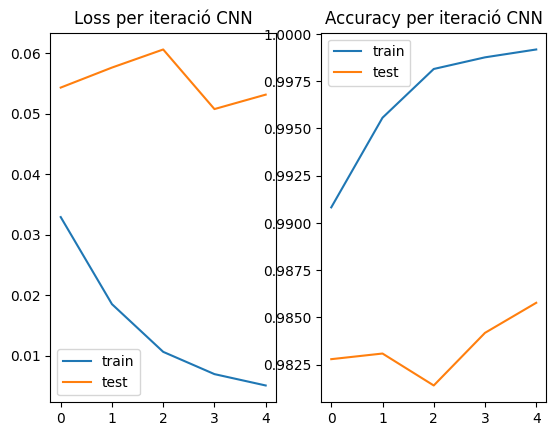

In [24]:
plt.subplot(1,2,1)
plt.title("Loss per iteració CNN")
plt.plot(running_loss, label="train")
plt.plot(running_test_loss, label="test")
plt.legend()

plt.subplot(1,2,2)
plt.title("Accuracy per iteració CNN")
plt.plot(running_acc, label="train")
plt.plot(running_test_acc_cnn, label="test")
plt.legend()
plt.show()

In [23]:
running_test_acc_cnn[-1]

0.9857683121019108

Ara mirarem el nombre de paràmetres que té aquesta xarxa:

In [ ]:
# TODO: COPIAR I ADAPTAR

## Resultats

Aquí visualitzarem els resultats d'aprenentatge de la xarxa. 

### Feina a fer:

1. Fer una predicció del primer _batch_ del conjunt de _test_.
2. Visualitzar una imatge del _batch_ i posar la predicció i el ground truth com a títol.
3. Empra una _CNN_ per resoldre el problema dels ocells que vàrem veure la setmana passada.



In [25]:
# 1.

# Posem el model en mode avaluació
model_cnn.eval()

# Agafem el primer batch del test
x_test, y_test = next(iter(test_loader))

with torch.no_grad():  # No cal gradients
    y_pred = model_cnn(x_test)               # sortida [batch_size, 10]
    y_pred_classes = torch.argmax(y_pred, dim=1)  # classe predita per cada imatge

print("Prediccions del primer batch:", y_pred_classes)
print("Valors reals del primer batch:", y_test)

Prediccions del primer batch: tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6, 5,
        4, 0, 7, 4, 0, 1, 3, 1, 3, 4, 7, 2, 7, 1, 2, 1, 1, 7, 4, 2, 3, 5, 1, 2,
        4, 4, 6, 3, 5, 5, 6, 0, 4, 1, 9, 5, 7, 8, 9, 3])
Valors reals del primer batch: tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6, 5,
        4, 0, 7, 4, 0, 1, 3, 1, 3, 4, 7, 2, 7, 1, 2, 1, 1, 7, 4, 2, 3, 5, 1, 2,
        4, 4, 6, 3, 5, 5, 6, 0, 4, 1, 9, 5, 7, 8, 9, 3])


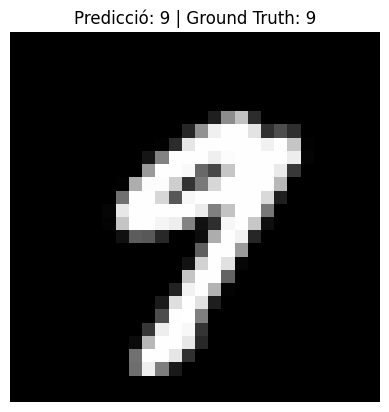

In [27]:
# 2.

import matplotlib.pyplot as plt

# Agafem la primera imatge del batch
img = x_test[20]           # tensor [1, 28, 28]
img = img.squeeze()       # treu la dimensió del canal → [28, 28]

# Predicció i valor real
pred = y_pred_classes[20].item()
true = y_test[20].item()

# Mostrar la imatge
plt.imshow(img, cmap="gray")
plt.title(f"Predicció: {pred} | Ground Truth: {true}")
plt.axis("off")
plt.show()